In [5]:
from collections import namedtuple
from graphviz import Digraph
from IPython.display import display

Operation = namedtuple('Operation', ['name', 'depends_on'])
ProcessStage = namedtuple('ProcessStage', ['operation', 'allocate_before', 'delete_after'])

In [9]:
def draw_graph(operations):
    dot = Digraph()
    
    for operation in operations:
        dot.node(operation.name)
        for dep in operation.depends_on:
            dot.edge(operation.name, dep)
    
    display(dot)
    
# draw_graph([
#     Operation(name='Test', depends_on=['Test2']),
#     Operation(name='Test2', depends_on=[]),
# ])

In [30]:
def execute_stages(stages, verbose=1, register_count=10):
    memory = []
    for r in range(register_count):
        memory.append([None, False])
        
    memory_map = {}
    if verbose > 0:
        print('      ', end='')
        for r in range(register_count):
            print('|  {}  '.format(r), end='')
        print('')
    
    def display_memory(prefix):
        if verbose <= 0:
            return
        print(prefix, end=' ')
        for item in memory:
            if item[0] == None:
                print('|     ', end='')
            else:
                print('| {} {} '.format(item[0], '☑' if item[1] else '☐'), end='')
        print('')
    
        
    for stage in stages:
        
        # Allocate Space
        for (op, addr) in stage.allocate_before:
            if verbose > 1:
                print("Allocating {} to {}".format(op, addr))
            assert memory[addr] == [None, False], "Overwrote existing memory"
            memory[addr] = [op, False]
            assert op not in memory_map, "Allocated operation again (was allocated in past, may currently be allocated)"
            memory_map[op] = addr
        
        display_memory('     ')
        # Perform Operation
        assert stage.operation.name in memory_map, "Operation has no output allocated"
        addr = memory_map[stage.operation.name]
        assert memory[addr][0] == stage.operation.name, "Operation ID's and Memory map disagree - implementation of execute_stages error"
        assert memory[addr][1] == False, "Running Operation Twice"
        
        if verbose > 1:
            print("Executing {}".format(stage.operation.name))
        
        for dep in stage.operation.depends_on:
            assert dep in memory_map, "Dependency not currently in memory"
            dep_addr = memory_map[dep]
            assert memory[dep_addr][0] == dep, "Operation Id's and Memory map disagree - implementation of execute_stages error"
            assert memory[dep_addr][1] == True, "Dependancy had not executed"
        
        memory[addr][1] = True
        
        display_memory('  ({})'.format(stage.operation.name))
        
        # Remove Old
        for op in stage.delete_after:
            if verbose > 1:
                print("Deleting {} from {}".format(op, addr))
            
            assert op in memory_map, "Operation deleted while not in memory"
            addr = memory_map[op]
            assert memory[addr][0] == op, "Operation ID's and Memory map disagree - implementation of execute_stages error"
            assert memory[addr][1] == True, "Operation deleted before computation"
            
            memory[addr] = [None, False]
            
        display_memory('     ')
            

            

A = Operation(name='A', depends_on=['B', 'G'])
B = Operation(name='B', depends_on=['C'])
C = Operation(name='C', depends_on=['D', 'F'])
D = Operation(name='D', depends_on=['E'])
E = Operation(name='E', depends_on=[])
F = Operation(name='F', depends_on=['E'])
G = Operation(name='G', depends_on=['F'])

            
        
stages = [
    ProcessStage(operation=E, allocate_before=[('E', 0)], delete_after=[]),
    ProcessStage(operation=F, allocate_before=[('F', 3)], delete_after=[]),
    ProcessStage(operation=G, allocate_before=[('G', 2)], delete_after=[]),
    ProcessStage(operation=D, allocate_before=[('D', 1)], delete_after=['E']),
    ProcessStage(operation=C, allocate_before=[('C', 0)], delete_after=['D', 'F']),
    ProcessStage(operation=B, allocate_before=[('B', 1)], delete_after=['C']),
    ProcessStage(operation=A, allocate_before=[('A', 0)], delete_after=['B', 'G']),
]
    
    
execute_stages(stages, verbose=1)
        

      |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  
      | E ☐ |     |     |     |     |     |     |     |     |     
  (E) | E ☑ |     |     |     |     |     |     |     |     |     
      | E ☑ |     |     |     |     |     |     |     |     |     
      | E ☑ |     |     | F ☐ |     |     |     |     |     |     
  (F) | E ☑ |     |     | F ☑ |     |     |     |     |     |     
      | E ☑ |     |     | F ☑ |     |     |     |     |     |     
      | E ☑ |     | G ☐ | F ☑ |     |     |     |     |     |     
  (G) | E ☑ |     | G ☑ | F ☑ |     |     |     |     |     |     
      | E ☑ |     | G ☑ | F ☑ |     |     |     |     |     |     
      | E ☑ | D ☐ | G ☑ | F ☑ |     |     |     |     |     |     
  (D) | E ☑ | D ☑ | G ☑ | F ☑ |     |     |     |     |     |     
      |     | D ☑ | G ☑ | F ☑ |     |     |     |     |     |     
      | C ☐ | D ☑ | G ☑ | F ☑ |     |     |     |     |     |     
  (C) | C ☑ | D ☑ | G ☑ | F ☑ |     |     |     |     |     | 

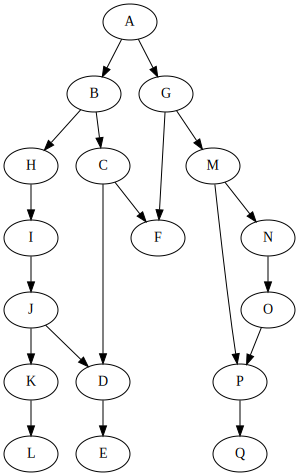

['A', None, None, None, None, None, None, None, None, None]
['A', 'B', 'G', None, None, None, None, None, None, None]
['C', 'B', 'G', 'H', None, None, None, None, None, None]
['C', 'I', 'G', 'H', None, None, None, None, None, None]
['C', 'I', 'G', 'J', None, None, None, None, None, None]
['C', 'D', 'G', 'J', 'F', None, None, None, None, None]
['M', 'D', 'G', 'J', 'F', None, None, None, None, None]
['M', 'D', None, 'J', 'F', None, None, None, None, None]
['M', 'D', 'N', 'J', 'P', None, None, None, None, None]
['O', 'D', 'N', 'J', 'P', None, None, None, None, None]
['O', 'D', None, 'J', 'P', None, None, None, None, None]
['Q', 'D', None, 'J', 'P', None, None, None, None, None]
['Q', 'D', None, 'J', None, None, None, None, None, None]
['K', 'D', None, 'J', None, None, None, None, None, None]
['K', 'D', 'L', None, None, None, None, None, None, None]
[None, 'D', 'L', None, None, None, None, None, None, None]
['E', 'D', None, None, None, None, None, None, None, None]
['E', None, None, None, 

In [69]:
def compute_execution(graph, memory_size=10):
    
    stages = []
    
    # TODO Implementation
    def get_requires(o):
        return [node for node in graph if o.name in node.depends_on]
    
    def get_by_name(name):
        possibilities = [o for o in graph if o.name == name]
        assert len(possibilities) != 0, "Node {} does not exist".format(name)
        assert len(possibilities) == 1, "Multiple Nodes with same name {}".format(name)
        return possibilities[0]
        
                
    
    output_nodes = [o for o in graph if get_requires(o) == []]
    assert len(output_nodes) == 1, "Multiple Output Nodes"
    output_node = output_nodes[0]
    
    prev_memory_state = [None] * memory_size
    prev_memory_state[0] = output_node.name
    stages.append(ProcessStage(operation=None, allocate_before=[], delete_after=[output_node.name]))
    
    remaining_ops = graph.copy()
        
    while 1:
        def filter_memory(n):
            for a in stages[-1].allocate_before:
                if a[0] == n:
                    return None
            return n
        
        new_memory_state = list(map(
            filter_memory,
            prev_memory_state
        ))
        print(prev_memory_state)
        
        available_ops = [o for o in new_memory_state if o is not None]
        candidate_operations = available_ops.copy()
        for op in remaining_ops:
            # TODO: Need to check all future operations not only ones in memory
            for req in op.depends_on:
                if req in candidate_operations:
                    candidate_operations.remove(req)
            
        if len(candidate_operations) == 0:
            assert len(available_ops) == 0, "Unable to find candidate operation, but there are still some remaining"
            assert len(remaining_ops) == 0, "Some operations were not executed"
            break
        
        # Sort the candidate operations so we pick the best one according to some heuristics
        candidate_operations.sort(key=lambda o: len(get_by_name(o).depends_on), reverse=False)
        
        operation_name = candidate_operations[0]
        operation = get_by_name(operation_name)
        remaining_ops.remove(operation)
        allocate_before = []
        delete_after = []
        
        for dep in operation.depends_on:
            if dep not in new_memory_state:
                free_index = new_memory_state.index(None) # ValueError = Out of memory
                new_memory_state[free_index] = dep
                
            if dep not in prev_memory_state:
                delete_after.append(dep)
        
        allocate_before.append((operation.name, new_memory_state.index(operation.name)))
            
        stage = ProcessStage(operation=operation, allocate_before=allocate_before, delete_after=delete_after)
        stages.append(stage)
        
        prev_memory_state = new_memory_state

    return list(reversed(stages))[:-1]


g1 = [
    Operation(name='A', depends_on=['B', 'G']),
    Operation(name='B', depends_on=['C', 'H']),
    Operation(name='C', depends_on=['D', 'F']),
    Operation(name='D', depends_on=['E']),
    Operation(name='E', depends_on=[]),
    Operation(name='F', depends_on=[]),
    Operation(name='G', depends_on=['F', 'M']),
    Operation(name='H', depends_on=['I']),
    Operation(name='I', depends_on=['J']),
    Operation(name='J', depends_on=['K', 'D']),
    Operation(name='K', depends_on=['L']),
    Operation(name='L', depends_on=[]),
    Operation(name='M', depends_on=['N', 'P']),
    Operation(name='N', depends_on=['O']),
    Operation(name='O', depends_on=['P']),
    Operation(name='P', depends_on=['Q']),
    Operation(name='Q', depends_on=[]),
]
draw_graph(g1)

    
stages = compute_execution(g1)
print('\n'.join([str(s) for s in stages]))
execute_stages(stages, verbose=1)